In [1]:
# Model Parameters
BATCH_SIZE = 4
EDGE_CROP = 16
NB_EPOCHS = 5
GAUSSIAN_NOISE = 0.1
UPSAMPLE_MODE = 'SIMPLE'

# downsampling inside the network
NET_SCALING = None

# downsampling in preprocessing
IMG_SCALING = (1,1)

# number of validation images to use
VALID_IMG_COUNT = 400

# maximum number of steps_per_epoch in training
MAX_TRAIN_STEPS = 200

AUGMENT_BRIGHTNESS = False

In [54]:
# Imports
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

ship_dir = 'input/'
train_image_dir = os.path.join(ship_dir, 'train_v2')
test_image_dir  = os.path.join(ship_dir, 'test_v2')

import gc; gc.enable()
from skimage.io import imread
from skimage.segmentation import mark_boundaries
from skimage.util.montage import montage2d as montage
from skimage.morphology import label
montage_rgb = lambda x: np.stack([montage(x[:, :, :, i]) for i in range(x.shape[3])], -1)

In [3]:
# Functions

def multi_rle_encode(img):
    labels = label(img[:,:,0])
    return [rle_encode(labels==k) for k in np.unique(labels[labels>0])]

def rle_encode(img):
    '''
    img: numpy array, 1 - mask, 0 - background
    Returns run length as string formated
    '''
    pixels = img.T.flatten()
    pixels = np.concatenate([[0], pixels, [0]])
    runs = np.where(pixels[1:] != pixels[:-1])[0] + 1
    runs[1::2] -= runs[::2]
    return ' '.join(str(x) for x in runs)

def rle_decode(mask_rle, shape=(768, 768)):
    '''
    mask_rle: run-length as string formated (start length)
    shape: (height,width) of array to return 
    Returns numpy array, 1 - mask, 0 - background
    '''
    rle_code = [int(i) for i in mask_rle.split()]
    starts, lengths = [np.asarray(x) for x in (rle_code[0::2], rle_code[1::2])]
    starts -= 1
    ends = starts + lengths
    img = np.zeros(shape[0]*shape[1], dtype=np.uint8)
    for lo, hi in zip(starts, ends):
        img[lo:hi] = 1
    return img.reshape(shape).T # Needed to align to RLE direction

def masks_as_img(in_mask_list):
    # Take the individual ship masks and create a single mask array for all ships
    all_masks = np.zeros((768, 768), dtype=np.uint8)
    #if isinstance(in_mask_list, list):
    for mask in in_mask_list:
        if isinstance(mask, str):
            all_masks += rle_decode(mask)
    return np.expand_dims(all_masks, -1)

In [4]:
ls input

sample_submission_v2.csv         train_ship_segmentations_v2.csv*
test_v2/                         train_v2/
train_box_pixels_v2.csv


In [5]:
masks = pd.read_csv(os.path.join(ship_dir, 'train_ship_segmentations_v2.csv'))

In [6]:
print(masks.shape[0], "masks found")
print(masks.ImageId.value_counts().shape[0], "unique images found")
masks.head()

231723 masks found
192556 unique images found


,ImageId,EncodedPixels
0,00003e153.jpg,NaN
1,0001124c7.jpg,NaN
2,000155de5.jpg,264661 17 265429 33 266197 33 266965 33 267733...
3,000194a2d.jpg,360486 1 361252 4 362019 5 362785 8 363552 10 ...
4,000194a2d.jpg,51834 9 52602 9 53370 9 54138 9 54906 9 55674 ...


Check Decoding -> Encoding RLE_0: 1 -> RLE_1: 1


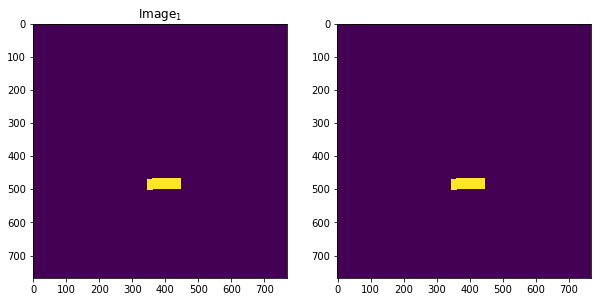

In [7]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,5))
rle_0 = masks.query('ImageId=="000155de5.jpg"')['EncodedPixels']
img_0 = masks_as_img(rle_0)
ax1.imshow(img_0[:,:,0])
ax1.set_title("Image$_0$")

rle_1 = multi_rle_encode(img_0)
img_1 = masks_as_img(rle_1)
ax2.imshow(img_0[:,:,0])
ax1.set_title("Image$_1$")

print("Check Decoding -> Encoding",
     'RLE_0:', len(rle_0), "->",
     'RLE_1:', len(rle_1))

In [8]:
masks['ships'] = masks['EncodedPixels'].apply(lambda x: 1 if isinstance(x, str) else 0)
unique_img_ids = masks.groupby('ImageId').agg({'ships':'sum'}).reset_index()
unique_img_ids['has_ship'] = unique_img_ids['ships'].apply(lambda x: 1 if x > 0 else 0)
unique_img_ids['has_ship_vec'] = unique_img_ids['has_ship'].apply(lambda x: [x])

unique_img_ids['file_size_kb'] = unique_img_ids['ImageId'].apply(lambda x: \
                                os.stat(os.path.join(train_image_dir, x)).st_size/1024)

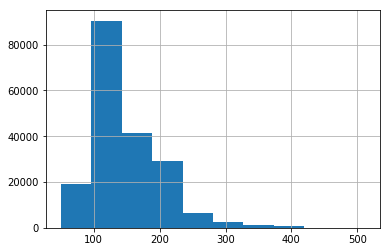

In [9]:
unique_img_ids = unique_img_ids[unique_img_ids['file_size_kb'] > 50]
unique_img_ids['file_size_kb'].hist()
masks.drop('ships', 1, inplace=True)

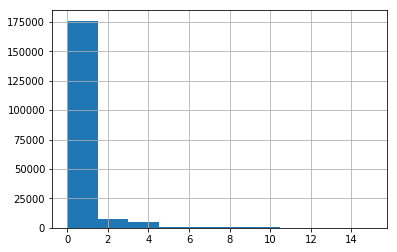

In [10]:
unique_img_ids['ships'].hist()

In [11]:
unique_img_ids.shape[0]

191289

In [12]:
from sklearn.model_selection import train_test_split

train_ids, valid_ids = train_test_split(unique_img_ids, test_size=0.3, \
                                        stratify=unique_img_ids['ships'])

In [13]:
print("train_ids:", train_ids.shape[0])
print("valid_ids: ", valid_ids.shape[0])
print("masks:    ", masks.shape[0])

train_ids: 133902
valid_ids:  57387
masks:     231723


In [14]:
train_df = pd.merge(masks, train_ids)
valid_df = pd.merge(masks, valid_ids)
print("train_df: ", train_df.shape[0])
print("valid_df:  ", valid_df.shape[0])
train_df.sample(5)

train_df:  161048
valid_df:   69034


,ImageId,EncodedPixels,ships,has_ship,has_ship_vec,file_size_kb
119466,be1ad4144.jpg,NaN,0,0,[0],105.428711
87098,8a85c3059.jpg,NaN,0,0,[0],249.865234
9121,0e4f7c17d.jpg,NaN,0,0,[0],123.513672
147034,e9edbff93.jpg,NaN,0,0,[0],143.231445
59945,5f259a8e9.jpg,NaN,0,0,[0],157.244141


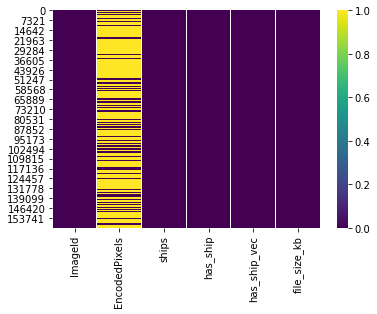

In [15]:
sns.heatmap(train_df.isnull(), cmap='viridis')

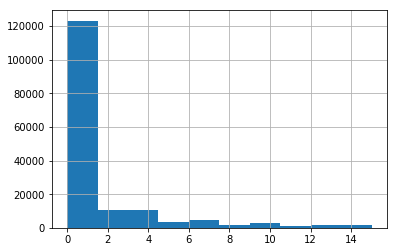

In [16]:
train_df['ships'].hist()

In [17]:
train_df['grouped_ship_count'] = train_df['ships'].apply(lambda x: (x+1)//2).clip(0,7)

In [18]:
def sample_ships(in_df, base_rep_val=1500):
    if in_df['ships'].values[0] == 0:
        return in_df.sample(base_rep_val//3)
    return in_df.sample(base_rep_val)

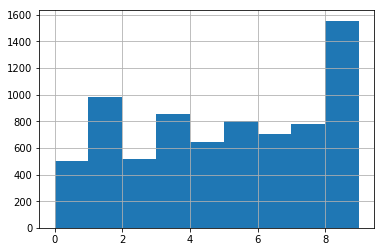

In [19]:
balanced_train_df = train_df.groupby('grouped_ship_count').apply(sample_ships)
balanced_train_df['ships'].hist(bins=np.arange(10))

In [38]:
def make_image_gen(in_df, batch_size=BATCH_SIZE):
    all_batches = list(in_df.groupby('ImageId'))
    out_rgb, out_mask = [], []
    while True:
        np.random.shuffle(all_batches)
        for img_id, masks in all_batches:
            rgb_path = os.path.join(train_image_dir, img_id)
            img = imread(rgb_path)
            mask = masks_as_img(masks['EncodedPixels'].values)
            if IMG_SCALING is not None:
                img = img[::IMG_SCALING[0], ::IMG_SCALING[1]]
                mask = mask[::IMG_SCALING[0], ::IMG_SCALING[1]]
            out_rgb += [img]
            out_mask += [mask]
            if len(out_rgb) >= batch_size:
                yield np.stack(out_rgb, 0)/255.0, np.stack(out_mask, 0)
                out_rgb, out_mask = [], []

In [39]:
train_gen = make_image_gen(balanced_train_df)

In [40]:
train_x, train_y = next(train_gen)
print('x', train_x.shape, train_x.min(), train_x.max())
print('y', train_y.shape, train_y.min(), train_y.max())

x (4, 768, 768, 3) 0.0 1.0
y (4, 768, 768, 1) 0 1


In [50]:
train_y[:, :, :, 0].shape

(4, 768, 768)

Text(0.5,1,'Outlined Ships')

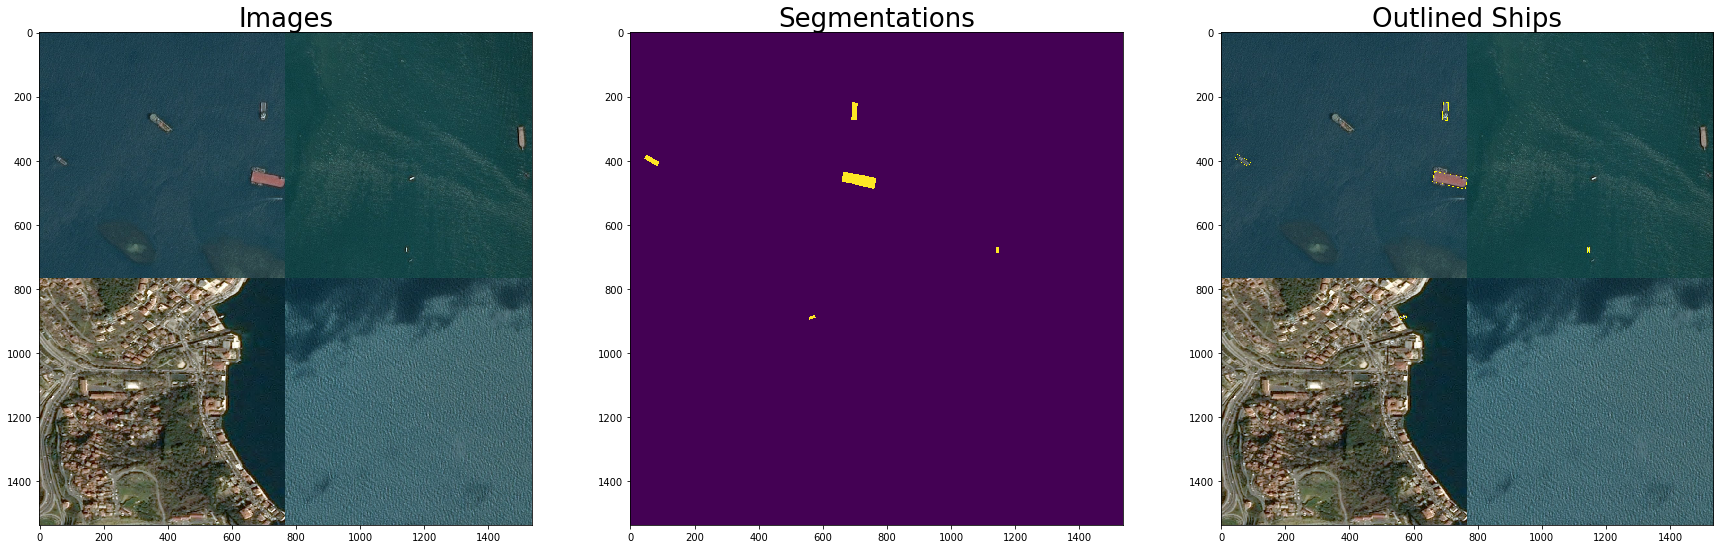

In [59]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(30, 10))
batch_rgb = montage_rgb(train_x)
batch_seg = montage(train_y[:,:,:,0])
ax1.imshow(batch_rgb)
ax2.imshow(batch_seg)
ax3.imshow(mark_boundaries(batch_rgb, batch_seg.astype(int)))

ax1.set_title('Images', fontsize=26)
ax2.set_title('Segmentations', fontsize=26)
ax3.set_title('Outlined Ships', fontsize=26)

In [61]:
valid_x, valid_y = next(make_image_gen(valid_df, VALID_IMG_COUNT))
print(valid_x.shape, valid_y.shape)

(400, 768, 768, 3) (400, 768, 768, 1)


In [63]:
from keras.preprocessing.image import ImageDataGenerator

/Users/Alex/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [76]:
dg_args = dict(featurewise_center = False,
              samplewise_center = False,
              rotation_range = 15,
              width_shift_range = 0.1,
              height_shift_range = 0.1,
              shear_range = 0.01,
              zoom_range = [0.9, 1.25],
              horizontal_flip = True,
              vertical_flip = True,
              fill_mode = 'reflect',
              data_format = 'channels_last',
              )

# brightness can be problematic since it seems to change the labels differently from the images 
if AUGMENT_BRIGHTNESS:
    dg_args['brightness_range'] = [0.5, 1.5]
image_gen = ImageDataGenerator(**dg_args)

if AUGMENT_BRIGHTNESS:
    dg_args.pop('brightness_range')
label_gen = ImageDataGenerator(**dg_args)

def create_aug_gen(in_gen, seed=None):
    np.random.seed(seed if seed is not None else np.random.choice(range(9999)))
    for in_x, in_y in in_gen:
        seed = np.random.choice(range(9999))
        # keep the seeds syncronized otherwise the augmentation to the images 
        # is different from the masks
        g_x = image_gen.flow(255*in_x, batch_size=in_x.shape[0], seed=seed, shuffle=True)
        g_y = label_gen.flow(in_y, batch_size=in_x.shape[0], seed=seed, shuffle=True)
        
        yield next(g_x)/255.0, next(g_y)

x (4, 768, 768, 3) float32 0.010562233 0.99767506
y (4, 768, 768, 1) float32 0.0 1.0


Text(0.5,1,'Ships')

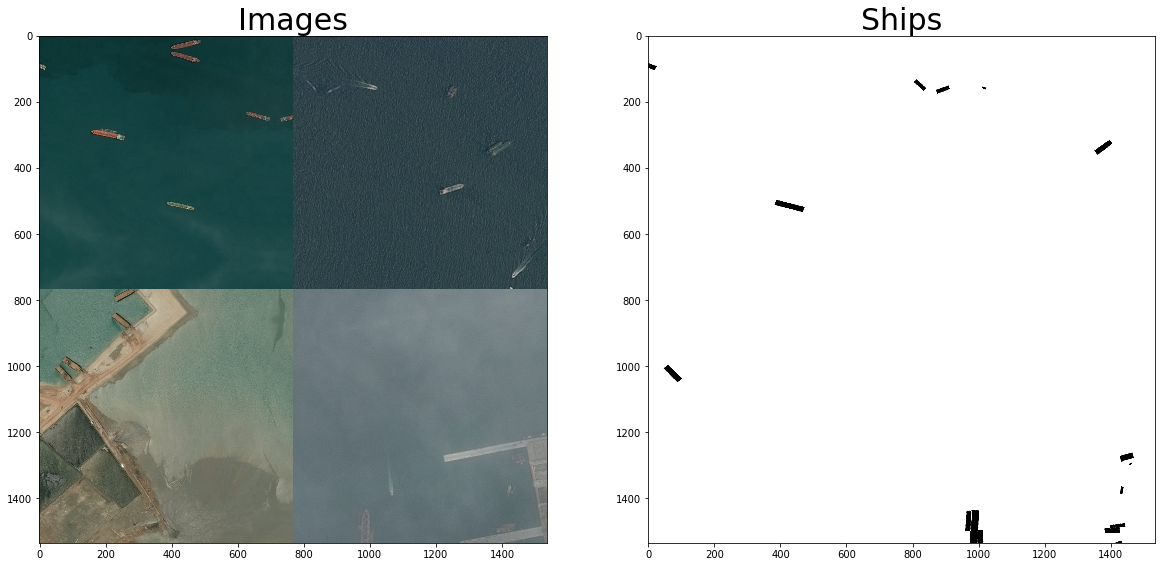

In [83]:
cur_gen = create_aug_gen(train_gen)
t_x, t_y = next(cur_gen)
    
print('x', t_x.shape, t_x.dtype, t_x.min(), t_x.max())
print('y', t_y.shape, t_y.dtype, t_y.min(), t_y.max())
# only keep first 9 samples to examine in detail
t_x = t_x[:9]
t_y = t_y[:9]

fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (20, 10))
ax1.imshow(montage_rgb(t_x))
ax1.set_title('Images', fontsize=30)

ax2.imshow(montage(t_y[:, :, :, 0]), cmap='gray_r')
ax2.set_title('Ships', fontsize=30)

In [84]:
gc.collect()

1319

In [91]:
from keras import models, layers

# Build U-Net model
def upsample_conv(filters, kernel_size, strides, padding):
    return layers.Conv2DTranspose(filters, kernel_size, strides=strides, padding=padding)
def upsample_simple(filters, kernel_size, strides, padding):
    return layers.UpSampling2D(strides)

if UPSAMPLE_MODE == 'DECONV':
    upsample = upsample_conv
else:
    upsample = upsample_simple

input_img = layers.Input(t_x.shape[1:], name="RGB_Input")
pp_in_layer = input_img
if NET_SCALING is not None:
    pp_in_layer = layers.AvgPool2D(NET_SCALING)(pp_in_layer)
    
pp_in_layer = layers.GaussianNoise(GAUSSIAN_NOISE)(pp_in_layer)
pp_in_layer = layers.BatchNormalization()(pp_in_layer)

c1 = layers.Conv2D(8, (3, 3), activation='relu', padding='same') (pp_in_layer)
c1 = layers.Conv2D(8, (3, 3), activation='relu', padding='same') (c1)
p1 = layers.MaxPooling2D((2, 2)) (c1)

c2 = layers.Conv2D(16, (3, 3), activation='relu', padding='same') (p1)
c2 = layers.Conv2D(16, (3, 3), activation='relu', padding='same') (c2)
p2 = layers.MaxPooling2D((2, 2)) (c2)

c3 = layers.Conv2D(32, (3, 3), activation='relu', padding='same') (p2)
c3 = layers.Conv2D(32, (3, 3), activation='relu', padding='same') (c3)
p3 = layers.MaxPooling2D((2, 2)) (c3)

c4 = layers.Conv2D(64, (3, 3), activation='relu', padding='same') (p3)
c4 = layers.Conv2D(64, (3, 3), activation='relu', padding='same') (c4)
p4 = layers.MaxPooling2D(pool_size=(2, 2)) (c4)


c5 = layers.Conv2D(128, (3, 3), activation='relu', padding='same') (p4)
c5 = layers.Conv2D(128, (3, 3), activation='relu', padding='same') (c5)

u6 = upsample(64, (2, 2), strides=(2, 2), padding='same') (c5)
u6 = layers.concatenate([u6, c4])
c6 = layers.Conv2D(64, (3, 3), activation='relu', padding='same') (u6)
c6 = layers.Conv2D(64, (3, 3), activation='relu', padding='same') (c6)

u7 = upsample(32, (2, 2), strides=(2, 2), padding='same') (c6)
u7 = layers.concatenate([u7, c3])
c7 = layers.Conv2D(32, (3, 3), activation='relu', padding='same') (u7)
c7 = layers.Conv2D(32, (3, 3), activation='relu', padding='same') (c7)

u8 = upsample(16, (2, 2), strides=(2, 2), padding='same') (c7)
u8 = layers.concatenate([u8, c2])
c8 = layers.Conv2D(16, (3, 3), activation='relu', padding='same') (u8)
c8 = layers.Conv2D(16, (3, 3), activation='relu', padding='same') (c8)

u9 = upsample(8, (2, 2), strides=(2, 2), padding='same') (c8)
u9 = layers.concatenate([u9, c1], axis=3)
c9 = layers.Conv2D(8, (3, 3), activation='relu', padding='same') (u9)
c9 = layers.Conv2D(8, (3, 3), activation='relu', padding='same') (c9)

d = layers.Conv2D(1, (1, 1), activation='sigmoid') (c9)
d = layers.Cropping2D((EDGE_CROP, EDGE_CROP))(d)
d = layers.ZeroPadding2D((EDGE_CROP, EDGE_CROP))(d)
if NET_SCALING is not None:
    d = layers.UpSampling2D(NET_SCALING)(d)

seg_model = models.Model(inputs=[input_img], outputs=[d])
seg_model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
RGB_Input (InputLayer)          (None, 768, 768, 3)  0                                            
__________________________________________________________________________________________________
gaussian_noise_2 (GaussianNoise (None, 768, 768, 3)  0           RGB_Input[0][0]                  
__________________________________________________________________________________________________
batch_normalization_2 (BatchNor (None, 768, 768, 3)  12          gaussian_noise_2[0][0]           
__________________________________________________________________________________________________
conv2d_20 (Conv2D)              (None, 768, 768, 8)  224         batch_normalization_2[0][0]      
__________________________________________________________________________________________________
conv2d_21 

In [96]:
import keras.backend as K
from keras.optimizers import Adam
from keras.losses import binary_crossentropy

def dice_coef(y_true, y_pred, smooth=1):
    intersection = K.sum(y_true * y_pred, axis=[1,2,3])
    union = K.sum(y_true, axis=[1,2,3]) + K.sum(y_pred, axis=[1,2,3])
    return K.mean((2.0 * intersection + smooth)/(union + smooth), axis=0)

def dice_p_bce(in_gt, in_pred):
    return 1e-3*binary_crossentropy(in_gt, in_pred) - dice_coef(in_gt, in_pred)

def true_positive_rate(y_true, y_pred):
    return K.sum(K.flatten(y_true) * K.flatten(K.round(y_pred))) / K.sum(y_true)

seg_model.compile(optimizer=Adam(1e-4, decay=1e-6), loss=dice_p_bce, \
                  metrics=[dice_coef, 'binary_accuracy', true_positive_rate])

In [97]:
from keras.callbacks import ModelCheckpoint, LearningRateScheduler, EarlyStopping, ReduceLROnPlateau
weight_path="{}_weights.best.hdf5".format('seg_model')

checkpoint = ModelCheckpoint(weight_path, monitor='val_dice_coef', verbose=1, 
                             save_best_only=True, mode='max', save_weights_only = True)

reduceLROnPlat = ReduceLROnPlateau(monitor='val_dice_coef', factor=0.5, 
                                   patience=3, 
                                   verbose=1, mode='max', epsilon=0.0001, cooldown=2, min_lr=1e-6)
early = EarlyStopping(monitor="val_dice_coef", 
                      mode="max", 
                      patience=15) # probably needs to be more patient, but kaggle time is limited
callbacks_list = [checkpoint, early, reduceLROnPlat]

/Users/Alex/anaconda3/lib/python3.6/site-packages/keras/callbacks.py:1065: UserWarning: `epsilon` argument is deprecated and will be removed, use `min_delta` instead.
  warnings.warn('`epsilon` argument is deprecated and '


In [ ]:
# VERY LONG PROCESS

step_count = min(MAX_TRAIN_STEPS, balanced_train_df.shape[0]//BATCH_SIZE)
aug_gen = create_aug_gen(make_image_gen(balanced_train_df))
loss_history = [seg_model.fit_generator(aug_gen, 
                             steps_per_epoch=step_count, 
                             epochs=NB_EPOCHS, 
                             validation_data=(valid_x, valid_y),
                             callbacks=callbacks_list,
                             workers=1 # the generator is not very thread safe
                             )]

Epoch 1/5
 16/200 [=>............................] - ETA: 1:52:56 - loss: -0.0046 - dice_coef: 0.0053 - binary_accuracy: 0.0871 - true_positive_rate: 0.9247

KeyboardInterrupt: 